In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
# --- Célula 2: Carregamento dos Dados (VERSÃO ATUALIZADA PARA MÚLTIPLOS ANOS) ---
import glob

# Carregar a tabela de features v3 (resultado do notebook 04)
path_base = '../data/processed/feature_table_v3.parquet'
df_base = pd.read_parquet(path_base)
print(f"Tabela base carregada com {df_base.shape[0]} registros e {df_base.shape[1]} colunas.")

# --- Lógica para carregar múltiplos arquivos anuais ---
def carregar_dados_anuais(caminho_padrao, separador=';', decimal=','):
    """Função para encontrar, ler e concatenar múltiplos arquivos CSV anuais."""
    lista_arquivos = glob.glob(caminho_padrao)
    if not lista_arquivos:
        raise FileNotFoundError(f"Nenhum arquivo encontrado para o padrão: {caminho_padrao}")
    lista_dfs = []
    for arquivo in lista_arquivos:
        print(f"Lendo o arquivo: {arquivo}")
        df_ano = pd.read_csv(arquivo, sep=separador, decimal=decimal)
        lista_dfs.append(df_ano)
    return pd.concat(lista_dfs, ignore_index=True)

try:
    print("\n--- Carregando dados de EAR ---")
    padrao_ear = '../data/raw/EAR_DIARIO_SUBSISTEMA_*.csv'
    df_ear_raw = carregar_dados_anuais(padrao_ear)
    print(f"-> {len(df_ear_raw)} registros de EAR carregados.")
    
    print("\n--- Carregando dados de ENA ---")
    padrao_ena = '../data/raw/ENA_DIARIO_SUBSISTEMA_*.csv'
    df_ena_raw = carregar_dados_anuais(padrao_ena)
    print(f"-> {len(df_ena_raw)} registros de ENA carregados.")

except Exception as e:
    print(f"ERRO CRÍTICO: Falha ao ler os arquivos CSV. Verifique os nomes e caminhos. Erro: {e}")
    raise

Tabela base carregada com 1349 registros e 11 colunas.

--- Carregando dados de EAR ---
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2022.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2021.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2025.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2024.csv
Lendo o arquivo: ../data/raw/EAR_DIARIO_SUBSISTEMA_2023.csv
-> 6960 registros de EAR carregados.

--- Carregando dados de ENA ---
Lendo o arquivo: ../data/raw/ENA_DIARIO_SUBSISTEMA_2021.csv
Lendo o arquivo: ../data/raw/ENA_DIARIO_SUBSISTEMA_2025.csv
Lendo o arquivo: ../data/raw/ENA_DIARIO_SUBSISTEMA_2023.csv
Lendo o arquivo: ../data/raw/ENA_DIARIO_SUBSISTEMA_2022.csv
Lendo o arquivo: ../data/raw/ENA_DIARIO_SUBSISTEMA_2024.csv
-> 6960 registros de ENA carregados.


In [3]:
# --- Célula 3: Processamento - Energia Armazenada (EAR) ---

coluna_data_ear = 'ear_data'
coluna_subsistema_ear = 'nom_subsistema'
coluna_valor_ear = 'ear_verif_subsistema_percentual'

df_ear = df_ear_raw[[coluna_data_ear, coluna_subsistema_ear, coluna_valor_ear]].copy()
df_ear.rename(columns={coluna_valor_ear: 'ear_percentual_seco'}, inplace=True)

df_ear['timestamp'] = pd.to_datetime(df_ear[coluna_data_ear])

# CORREÇÃO: Usando o nome 'SUDESTE', conforme encontrado no arquivo.
df_ear_seco = df_ear[df_ear[coluna_subsistema_ear] == 'SUDESTE'].copy()

df_ear_seco.set_index('timestamp', inplace=True)

print("Feature de Energia Armazenada (EAR) foi criada.")
display(df_ear_seco.head())

Feature de Energia Armazenada (EAR) foi criada.


,ear_data,nom_subsistema,ear_percentual_seco
timestamp,,,
2022-01-01,2022-01-01,SUDESTE,26.20409966
2022-01-02,2022-01-02,SUDESTE,26.79140091
2022-01-03,2022-01-03,SUDESTE,27.28499985
2022-01-04,2022-01-04,SUDESTE,27.84519958
2022-01-05,2022-01-05,SUDESTE,28.47249985


In [4]:
# --- Célula 4: Processamento - Energia Afluente (ENA) ---

coluna_data_ena = 'ena_data'
coluna_subsistema_ena = 'nom_subsistema'
coluna_valor_ena_percentual = 'ena_bruta_regiao_percentualmlt'

df_ena = df_ena_raw[[coluna_data_ena, coluna_subsistema_ena, coluna_valor_ena_percentual]].copy()
df_ena.rename(columns={coluna_valor_ena_percentual: 'ena_percentual_mlt_seco'}, inplace=True)

df_ena['timestamp'] = pd.to_datetime(df_ena[coluna_data_ena])

# CORREÇÃO: Usando o nome 'SUDESTE', conforme encontrado no arquivo.
df_ena_seco = df_ena[df_ena[coluna_subsistema_ena] == 'SUDESTE'].copy()

df_ena_seco.set_index('timestamp', inplace=True)

print("Feature de Energia Afluente (ENA) foi criada.")
display(df_ena_seco.head())

Feature de Energia Afluente (ENA) foi criada.


,ena_data,nom_subsistema,ena_percentual_mlt_seco
timestamp,,,
2021-01-01,2021-01-01,SUDESTE,62.56110001
2021-01-02,2021-01-02,SUDESTE,63.36510086
2021-01-03,2021-01-03,SUDESTE,64.60939789
2021-01-04,2021-01-04,SUDESTE,65.90630341
2021-01-05,2021-01-05,SUDESTE,66.93360138


In [5]:
# --- Célula 5: Junção (Merge) de Todas as Features (VERSÃO COM IMPUTAÇÃO) ---

# Começa com a tabela base do notebook anterior
df_combinado = df_base.copy()

# Adiciona as novas features hídricas
df_combinado = df_combinado.join(df_ear_seco[['ear_percentual_seco']])
df_combinado = df_combinado.join(df_ena_seco[['ena_percentual_mlt_seco']])

# --- CORREÇÃO: Tratamento de Nulos com Preenchimento ---
# Em vez de apagar linhas com dados faltantes, vamos preenchê-las.
# Usamos ffill() (forward fill) para preencher um dia sem dados com o valor do dia anterior.
# Em seguida, bfill() (backward fill) preenche os dias que possam ter ficado em branco no início do período.
df_combinado['ear_percentual_seco'].ffill(inplace=True)
df_combinado['ena_percentual_mlt_seco'].ffill(inplace=True)
df_combinado.bfill(inplace=True) # Garante que o início do dataset não tenha nulos

# Para outras colunas que possam ter ficado nulas, preenchemos com 0.
df_combinado.fillna(0, inplace=True)

print("Tabela final combinada (Alvo + Carga + Geração + Rede + Hídrica):")
# Verificando se ainda há algum nulo
print("Contagem de nulos após o preenchimento:")
print(df_combinado.isnull().sum())
display(df_combinado.head())

Tabela final combinada (Alvo + Carga + Geração + Rede + Hídrica):
Contagem de nulos após o preenchimento:
deficit_diario_mwh              0
nivel_risco                     0
programada                      0
verificada                      0
diferenca_verif_prog            0
geracao_total_diaria_go         0
geracao_fotovoltaica_diaria     0
geracao_hidroelétrica_diaria    0
geracao_térmica_diaria          0
total_mwh_restrito_go           0
saldo_intercambio_seco          0
ear_percentual_seco             0
ena_percentual_mlt_seco         0
dtype: int64


/tmp/ipykernel_262137/293271397.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_combinado['ear_percentual_seco'].ffill(inplace=True)
/tmp/ipykernel_262137/293271397.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=T

,deficit_diario_mwh,nivel_risco,programada,verificada,diferenca_verif_prog,geracao_total_diaria_go,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_térmica_diaria,total_mwh_restrito_go,saldo_intercambio_seco,ear_percentual_seco,ena_percentual_mlt_seco
timestamp,,,,,,,,,,,,,
2022-01-02,0.05,baixo,70028.7895,70799.8310,771.0415,0.0,0.0,0.0,0.0,0.0,0.0,26.79140091,94.13210297
2022-01-03,0.00,baixo,84184.8645,81653.0526,-2531.8119,0.0,0.0,0.0,0.0,0.0,0.0,27.28499985,95.48090363
2022-01-04,0.00,baixo,83897.3920,85507.4336,1610.0416,0.0,0.0,0.0,0.0,0.0,0.0,27.84519958,101.48020172
2022-01-05,0.00,baixo,82665.9489,88303.1347,5637.1858,0.0,0.0,0.0,0.0,0.0,0.0,28.47249985,104.05729675
2022-01-06,0.00,baixo,81595.0781,85423.2342,3828.1561,0.0,0.0,0.0,0.0,0.0,0.0,29.09530067,104.28050232


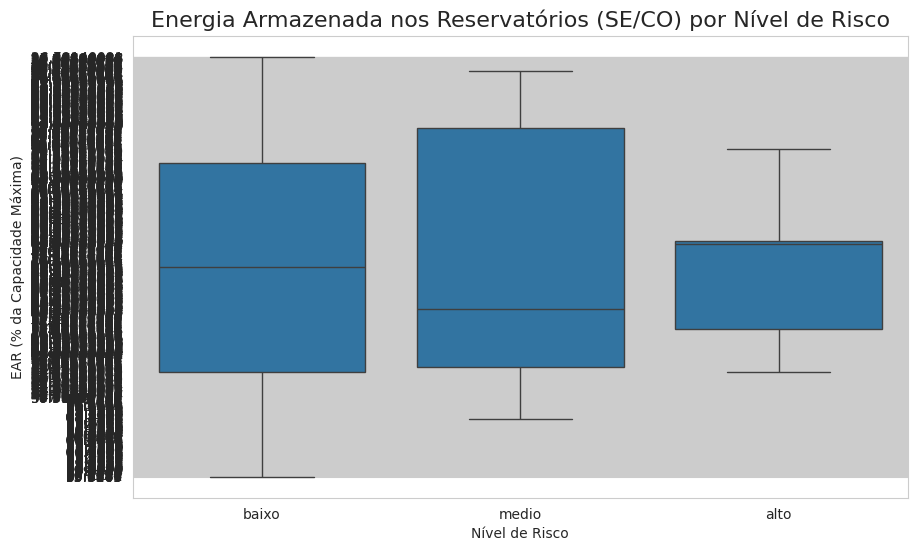

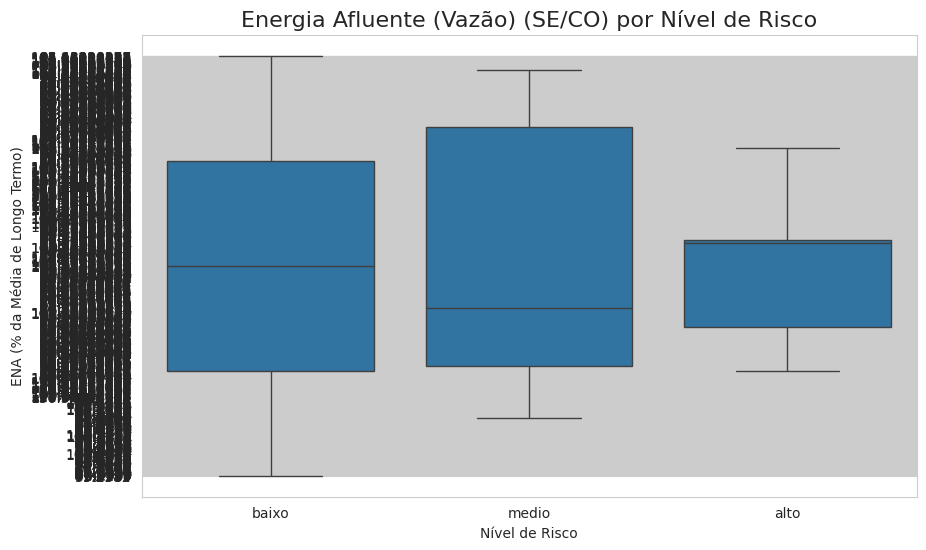

In [6]:
# Gráfico 1: Energia Armazenada (EAR) por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='ear_percentual_seco', data=df_combinado, order=['baixo', 'medio', 'alto'])
plt.title('Energia Armazenada nos Reservatórios (SE/CO) por Nível de Risco', fontsize=16)
plt.ylabel('EAR (% da Capacidade Máxima)')
plt.xlabel('Nível de Risco')
plt.show()

# Gráfico 2: Energia Afluente (ENA) por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='ena_percentual_mlt_seco', data=df_combinado, order=['baixo', 'medio', 'alto'])
plt.title('Energia Afluente (Vazão) (SE/CO) por Nível de Risco', fontsize=16)
plt.ylabel('ENA (% da Média de Longo Termo)')
plt.xlabel('Nível de Risco')
plt.show()

In [7]:
# --- Célula 7: Salvando a Tabela Final para Modelagem ---

# Define e cria o diretório de saída se não existir
output_path = '../data/processed/feature_table_final.parquet'
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# Salva a tabela final, pronta para a fase de Machine Learning
df_combinado.to_parquet(output_path)

print(f"TABELA FINAL PRONTA PARA MODELAGEM salva com sucesso em: {output_path}")
print(f"A tabela contém {df_combinado.shape[0]} dias e {df_combinado.shape[1]} colunas (features + alvo).")

TABELA FINAL PRONTA PARA MODELAGEM salva com sucesso em: ../data/processed/feature_table_final.parquet
A tabela contém 1349 dias e 13 colunas (features + alvo).
